In [21]:
import re
from collections import Counter, defaultdict
from copy import deepcopy
from tqdm import tqdm
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from spellchecker import SpellChecker
from textblob import TextBlob
from difflib import SequenceMatcher

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [22]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## 1. load and preprocess data

train_with_labels

In [6]:
file_path = '../data/train_with_labels.txt' 

with open(file_path, 'r', encoding='utf-8') as file:
    train_y = file.read()

print(train_y[:500])

Thank you so much, Chris. <eob> And it's truly a great honor <eol> to have the opportunity <eob> to come to this stage twice; <eol> I'm extremely grateful. <eob>
I have been blown away by this conference, <eob> and I want to thank all of you <eol> for the many nice comments <eob> about what I had to say the other night. <eob>
And I say that sincerely, <eob> partly because (Mock sob) <eob> I need that. <eob> (Laughter) <eob>
(Laughter) <eob> I flew on Air Force Two for eight years. <eob>
(Laughte


### train_without_labels

In [46]:
file_path = '../data/train_without_labels.txt' 

with open(file_path, 'r', encoding='utf-8') as file:
    train_x = file.read()

print(train_x[:200])

Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all o


In [47]:
train_x = train_x.strip()
sentences = train_x.split('\n')
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

print(tokenized_sentences[:5])

[['Thank', 'you', 'so', 'much', ',', 'Chris', '.', 'And', 'it', "'s", 'truly', 'a', 'great', 'honor', 'to', 'have', 'the', 'opportunity', 'to', 'come', 'to', 'this', 'stage', 'twice', ';', 'I', "'m", 'extremely', 'grateful', '.'], ['I', 'have', 'been', 'blown', 'away', 'by', 'this', 'conference', ',', 'and', 'I', 'want', 'to', 'thank', 'all', 'of', 'you', 'for', 'the', 'many', 'nice', 'comments', 'about', 'what', 'I', 'had', 'to', 'say', 'the', 'other', 'night', '.'], ['And', 'I', 'say', 'that', 'sincerely', ',', 'partly', 'because', '(', 'Mock', 'sob', ')', 'I', 'need', 'that', '.', '(', 'Laughter', ')'], ['(', 'Laughter', ')', 'I', 'flew', 'on', 'Air', 'Force', 'Two', 'for', 'eight', 'years', '.'], ['(', 'Laughter', ')', 'Now', 'I', 'have', 'to', 'take', 'off', 'my', 'shoes', 'or', 'boots', 'to', 'get', 'on', 'an', 'airplane', '!', '(', 'Laughter', ')', '(', 'Applause', ')']]


Establish a vocabulary and convert each senstence to a sequence of word indices

In [51]:
# Count the frequency of each token across all sentences
word_counts = Counter(token for sentence in tokenized_sentences for token in sentence)

# Sort the vocabulary in descending order of word frequency
vocab = sorted(word_counts, key=word_counts.get, reverse=True)

vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Map words to indices
word_to_index = {word: i+1 for i, word in enumerate(vocab)}

# Function to convert review to a sequence of word indices
def sentence_to_sequence(sentence, word_to_index):
    return [word_to_index.get(word, 0) for word in sentence]  # use 0 for unknown words

# Convert each review to a sequence of word indices
x_train = [sentence_to_sequence(sentence, word_to_index) for sentence in tokenized_sentences]

Vocabulary Size: 71729


In [52]:
print(word_counts)

Counter({',': 287400, '.': 233874, 'the': 185295, 'to': 117230, 'of': 108181, 'and': 100211, 'a': 97044, 'that': 84661, 'I': 77841, 'in': 69235, 'is': 60503, 'you': 58963, 'it': 55613, "'s": 52866, 'we': 51443, 'And': 40132, 'this': 38862, 'was': 29948, 'for': 26656, 'are': 26592, 'have': 26050, 'they': 24826, 'on': 23881, 'do': 23562, 'with': 22980, "n't": 20997, '?': 20797, 'So': 20772, 'what': 20532, 'can': 19999, 'about': 19889, 'be': 19009, '--': 18245, 'not': 17607, 'at': 17493, '``': 17434, 'as': 17244, 'all': 16627, 'there': 15924, "'re": 15840, 'people': 15214, 'It': 15035, "''": 15030, 'my': 14986, 'like': 14710, 'one': 14570, 'from': 14348, 'so': 14247, 'but': 13449, 'an': 13000, ')': 12951, '(': 12938, 'our': 12544, 'just': 12497, ':': 12394, 'or': 12361, 'We': 12256, 'But': 11844, 'these': 11740, 'if': 11550, 'very': 11541, 'The': 11529, 'me': 11325, 'out': 11312, 'them': 10960, 'know': 10813, 'by': 10760, 'going': 10729, 'up': 10435, 'had': 10328, 'when': 10286, 'because'

In [53]:
print(x_train[:5])

[[213, 12, 48, 119, 1, 1154, 2, 16, 13, 14, 1126, 7, 190, 2281, 4, 21, 3, 659, 4, 161, 4, 17, 785, 1479, 157, 9, 87, 944, 3312, 2], [9, 21, 113, 5014, 259, 67, 17, 1509, 1, 6, 9, 110, 4, 863, 38, 5, 12, 19, 3, 144, 766, 4208, 31, 29, 9, 70, 4, 132, 3, 107, 495, 2], [16, 9, 132, 8, 23265, 1, 3584, 72, 52, 32330, 23266, 51, 9, 138, 8, 2, 52, 94, 51], [52, 94, 51, 9, 2655, 23, 4867, 5181, 1370, 19, 673, 103, 2], [52, 94, 51, 109, 9, 21, 4, 145, 217, 44, 1890, 56, 5412, 4, 85, 23, 50, 2081, 284, 52, 94, 51, 52, 164, 51]]


Analyze sentence length

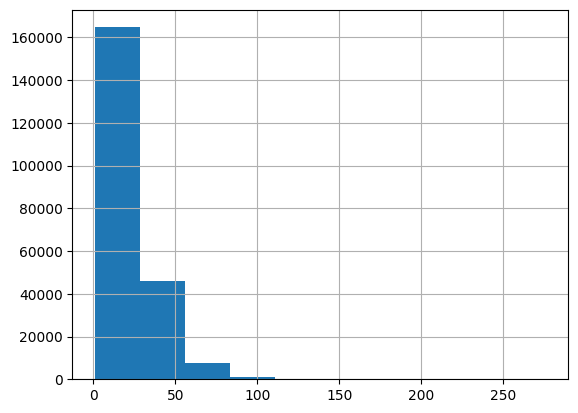

count    220068.000000
mean         22.073332
std          16.069037
min           1.000000
25%          11.000000
50%          18.000000
75%          29.000000
max         276.000000
dtype: float64

In [54]:
sent_len = [len(i) for i in x_train]
pd.Series(sent_len).hist()
plt.show()
pd.Series(sent_len).describe()

Pad each sentence to the length of 300

In [55]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for n, review in enumerate(sentences):
        if len(review) != 0:
            features[n, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding(x_train, 300)

In [56]:
print(x_train_pad)

[[   0    0    0 ...  944 3312    2]
 [   0    0    0 ...  107  495    2]
 [   0    0    0 ...   52   94   51]
 ...
 [   0    0    0 ...  416   45    2]
 [   0    0    0 ...  317  222    2]
 [   0    0    0 ...   52  868   51]]


Creating a Word Embedding Matrix using GloVe

In [58]:
# Load GloVe embeddings
embedding_dim = 200  
embeddings_index = {}
with open('glove.6B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(71730, 200)

Create PyTorch Datasets and DataLoaders

In [ ]:
class ReviewDataset(Dataset):
    
    def __init__(self, sequences, scores):
        self.sequences = sequences
        self.scores = scores
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.scores[idx], dtype=torch.long)

In [ ]:
train_dataset = ReviewDataset(x_train_pad, y_train)
#test_dataset = ReviewDataset(x_test_pad, y_test)

batch_size = 32

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Observe one batch of training data

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)